In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.19.0


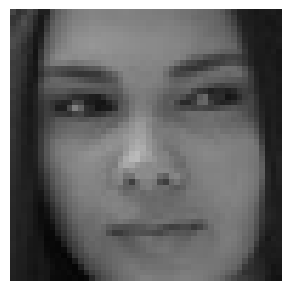

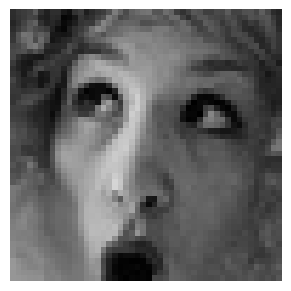

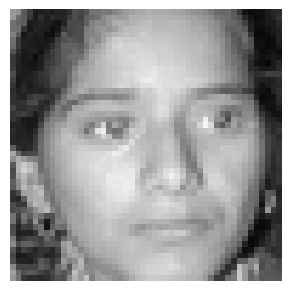

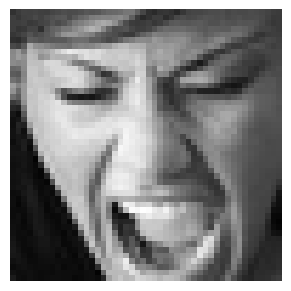

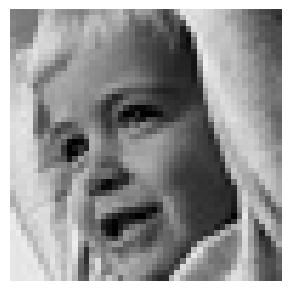

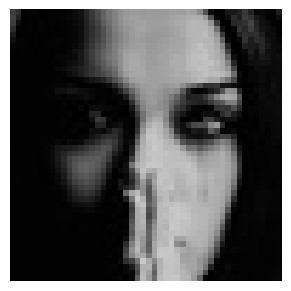

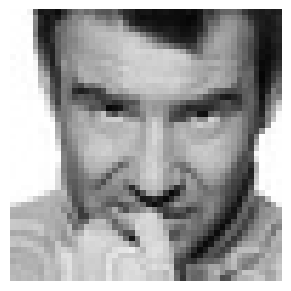

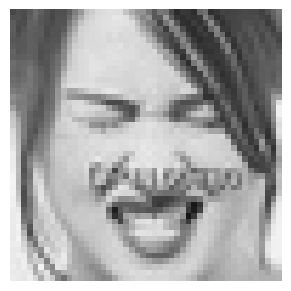

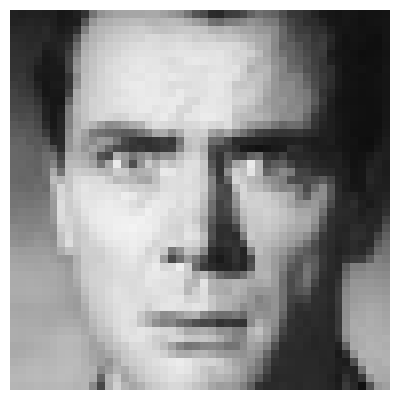

In [2]:
import matplotlib.pyplot as plt

images = glob("train/**/*", recursive=True)  # Added recursive search
images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Optional: filter image files

for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12, 12))  # Corrected syntax: figsize is a tuple
    plt.subplot(3, 3, i + 1)      # Corrected indexing for 3x3 grid
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [3]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64

# Data augmentation for training
datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = datagen_train.flow_from_directory(
    "train/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

# Data generator for validation
datagen_validation = ImageDataGenerator(rescale=1./255)

validation_generator = datagen_validation.flow_from_directory(
    "test/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Dense

def convolution_block(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

def dense_block(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# Assuming you've already defined:
# def convolution_block(input_tensor, filters, kernel_size)
# def dense_block(input_tensor, nodes)

def model_fer(input_shape):
    inputs = Input(shape=input_shape)

    conv_1 = convolution_block(inputs, 32, (3, 3))
    conv_2 = convolution_block(conv_1, 64, (5, 5))
    conv_3 = convolution_block(conv_2, 128, (3, 3))

    flatten = Flatten()(conv_3)
    dense_1 = dense_block(flatten, 256)

    output = Dense(7, activation="softmax")(dense_1)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create and summarize the model
model = model_fer((48, 48, 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │              

 Total params: 1,308,039 (4.99 MB)

 Trainable params: 1,307,591 (4.99 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5",  # NOTE: must end with `.weights.h5` if save_weights_only=True
                             monitor='val_accuracy', 
                             save_weights_only=True, 
                             mode='max', 
                             verbose=1)

callbacks = [checkpoint]




In [6]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


C:\Users\harini p\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.2234 - loss: 2.3811  
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 102s 217ms/step - accuracy: 0.2234 - loss: 2.3801 - val_accuracy: 0.2473 - val_loss: 1.8011
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:04 145ms/step - accuracy: 0.2656 - loss: 1.7786

C:\Users\harini p\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2656 - loss: 1.7786 - val_accuracy: 0.2472 - val_loss: 1.8013
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2535 - loss: 1.8071  
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 97s 216ms/step - accuracy: 0.2535 - loss: 1.8071 - val_accuracy: 0.2525 - val_loss: 1.7937
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:15 169ms/step - accuracy: 0.2500 - loss: 1.8282
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2500 - loss: 1.8282 - val_accuracy: 0.2529 - val_loss: 1.7938
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2518 - loss: 1.8025  
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 96s 214ms/step - accuracy: 0.2518 - loss: 1.8025 - val_accuracy: 0.2479 - val_loss: 1.8033
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:07 152ms/st

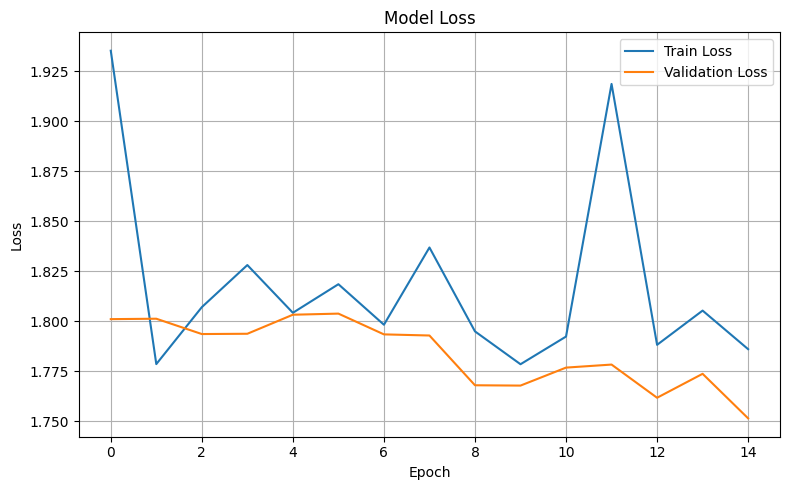

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights.h5")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import model_from_json, Model

# Load model
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
model.load_weights("model_weights.h5")
print("✅ Model loaded.")

# Load and preprocess test image
img = cv2.imread("test_face.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (48, 48))
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=[0, -1])  # shape: (1, 48, 48, 1)

# Get conv layer outputs
layer_names = [layer.name for layer in model.layers if "conv" in layer.name]
conv_outputs = [model.get_layer(name).output for name in layer_names[:4]]
activation_model = Model(inputs=model.input, outputs=conv_outputs)
activations = activation_model.predict(img)

# Visualize activation maps
for layer_activation, layer_name in zip(activations, layer_names[:4]):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    display_grid = np.zeros((size, size * 8))  # 8 filters

    for i in range(8):
        activation_map = layer_activation[0, :, :, i]
        activation_map -= activation_map.mean()
        activation_map /= (activation_map.std() + 1e-5)
        activation_map *= 255
        activation_map = np.clip(activation_map, 0, 255).astype("uint8")
        display_grid[:, i * size: (i + 1) * size] = activation_map

    plt.figure(figsize=(15, 5))
    plt.title(f"Activation maps - {layer_name}")
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.axis('off')
    plt.show()


In [1]:
from tensorflow.keras.models import model_from_json

# Load model architecture
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

# Load weights
model.load_weights("model_weights.h5")
print("✅ Model loaded.")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)